# Estimate Lowpass Filter Parameters via Gradient Descent

This notebook demonstrates how to estimate the parameters of a lowpass biquad filter (cutoff frequency and Q factor) using gradient descent. We will simulate a target signal by filtering white noise with known filter parameters, and then attempt to recover those parameters by minimising the distance between the filtered signal and the target signal.

We will use the `lfilter` and `lfilter_zi` function from `philtorch.lti` to apply the filter and handle initial conditions properly.

In [1]:
import torch
from torch import optim
import torch.nn.functional as F
from philtorch.lti import filtfilt, lfilter, lfilter_zi
from IPython.display import Audio
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

### Define Lowpass Biquad Coefficient Function

In [2]:
# copied from https://github.com/SonyResearch/diffvox/
def lowpass_biquad_coef(
    sample_rate: int,
    cutoff_freq: torch.Tensor,
    Q: torch.Tensor,
):
    w0 = 2 * torch.pi * cutoff_freq / sample_rate
    alpha = torch.sin(w0) / 2 / Q

    b0 = (1 - torch.cos(w0)) / 2
    b1 = 1 - torch.cos(w0)
    b2 = b0
    a0 = 1 + alpha
    a1 = -2 * torch.cos(w0)
    a2 = 1 - alpha
    b = torch.stack([b0, b1, b2], dim=-1) / a0
    a = torch.stack([a1, a2], dim=-1) / a0
    return b, a

### Define Signal and Target Filter Parameters

We will use a sample rate of 16 kHz and a duration of 6 seconds. The target filter will have a cutoff frequency of 1000 Hz and a Q factor of 5.0.
For simplicity, the input signal will be white noise.

In [3]:
sr = 16000
T = 6
target_cutoff = 1000.0
target_Q = 10.0
device = "cuda"
param2coefs = partial(lowpass_biquad_coef, sr)

In [4]:
x = torch.randn(1, sr * T, device=device)
b_target, a_target = param2coefs(
    torch.tensor(target_cutoff, device=device), torch.tensor(target_Q, device=device)
)
zi = lfilter_zi(a_target, b_target)
y, _ = lfilter(b_target, a_target, x, zi=zi * x[:, :1])

In [5]:
Audio(x.cpu().numpy(), rate=sr)

The input signal is lowpass filtered with resonance at 1 kHz.

In [6]:
Audio(y.cpu().numpy(), rate=sr)

### Initialise Estimated Filter Parameters and Optimiser

We will initialise the estimated cutoff frequency to 200 Hz and the Q factor to 0.707.
I emprically found that initialising the cutoff frequency lower than the target helps with convergence.

In [7]:
est_cutoff = torch.nn.Parameter(
    torch.tensor(200.0, device=device)
)
est_Q = torch.nn.Parameter(
    torch.tensor(0.707, device=device)
)
optimizer = optim.Adam([est_cutoff, est_Q], lr=0.2)


### Training Loop
The loss we will use is the mean squared error between the estimated output signal and the target output signal.

In [8]:
loss_history = []
cutoff_history = []
Q_history = []

with tqdm(range(20000)) as pbar:
    for step in pbar:
        b_est, a_est = param2coefs(est_cutoff, est_Q)
        zi = lfilter_zi(a_est, b_est)
        y_est, _ = lfilter(b_est, a_est, x, zi=zi * x[:, :1])
        loss = F.mse_loss(y_est, y)
        loss_history.append(loss.item())
        cutoff_history.append(est_cutoff.item())
        Q_history.append(est_Q.item())

        if loss.item() < 1e-6:
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(
            f"loss: {loss.item():.6f}, cutoff: {est_cutoff.item():.2f}, Q: {est_Q.item():.2f}"
        )

loss: 0.000001, cutoff: 999.96, Q: 10.00:  12%|█▏        | 2364/20000 [00:10<01:20, 218.87it/s]


### Results

In [9]:
Audio(y_est.detach().cpu().numpy(), rate=sr)

### Optimisation Progress

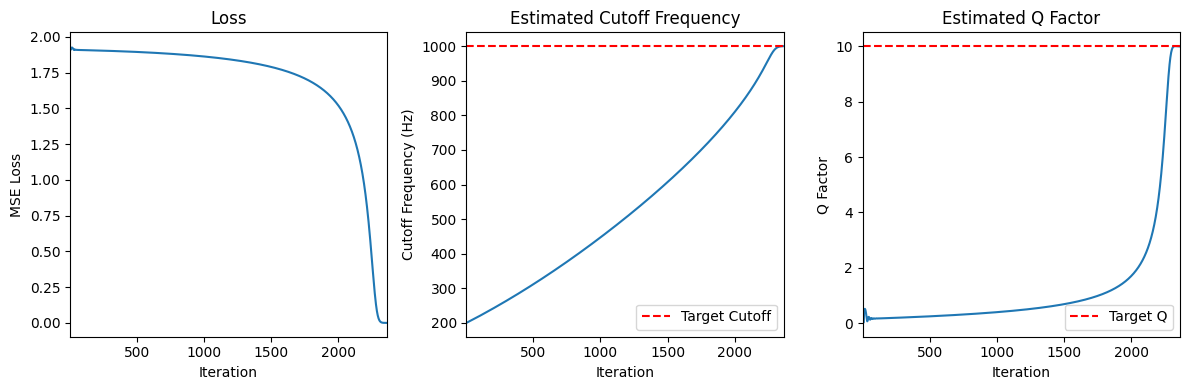

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

ax[0].plot(loss_history)
ax[0].set_title("Loss")
ax[0].set_xlabel("Iteration")
ax[0].set_xlim(1, len(loss_history))
ax[0].set_ylabel("MSE Loss")
ax[1].plot(cutoff_history)
ax[1].set_title("Estimated Cutoff Frequency")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Cutoff Frequency (Hz)")
ax[1].axhline(target_cutoff, color="red", linestyle="--", label="Target Cutoff")
ax[1].legend()
ax[2].plot(Q_history)
ax[2].set_title("Estimated Q Factor")
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Q Factor")
ax[2].axhline(target_Q, color="red", linestyle="--", label="Target Q")
ax[2].legend()
plt.tight_layout()
plt.show()